In [1]:
import math
import cv2 as cv
import numpy as np
import pandas as pd
from glob import glob
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from config import test_dataset_imagename_front,val_dataset_imagename_front


# ------------------ #
from tensorflow.keras import models, Sequential
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Balanceacc

from models import efficientNetV2B0_model, efficientNetV2B3_model
from config import efficientNet_config
from sklearn.utils import shuffle

from utils import plt_heatmap, plt_roccurve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc


import os
# 使用第一張 GPU 卡
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# 判斷膽管方向是 上面 或 下面 
# 用整張影像 分類模型

In [2]:
train_img_paths     = sorted(glob('../../classification/dataset_186video_20230323/train/1/*.png'))                  # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! 換資料集
val_img_paths       = sorted(glob('../../classification/dataset_186video_20230323/validation/1/*.png'))

train_img_arrays = []
train_img_labels = []
validation_img_arrays = []
validation_img_labels = []

for train_img_path in train_img_paths:
    img_array = cv.imread(train_img_path)
    img_array = cv.resize(img_array,(224, 224))     # efficientNetv2B0
    # image array
    train_img_arrays.append(img_array)
    # label
    train_img_labels.append([0])

    smoothed_img2_ROTATE_180 = cv.rotate(img_array, cv.ROTATE_180)   # 轉180度
    # image array(rotate 180) 
    train_img_arrays.append(smoothed_img2_ROTATE_180)
    # label(rotate 180)
    train_img_labels.append([1])

# 驗證集
for val_img_path in val_img_paths:
    img_array = cv.imread(val_img_path)
    img_array = cv.resize(img_array,(224, 224))     # efficientNetv2B0

    # image array
    validation_img_arrays.append(img_array)
    # label
    validation_img_labels.append([0])

    smoothed_img2_ROTATE_180 = cv.rotate(img_array, cv.ROTATE_180)
    # image array(rotate 180) 
    validation_img_arrays.append(smoothed_img2_ROTATE_180)
    # label(rotate 180)
    validation_img_labels.append([1])   
    

In [3]:
train_img_arrays = np.array(train_img_arrays)
train_img_labels = np.array(train_img_labels)
validation_img_arrays = np.array(validation_img_arrays)
validation_img_labels = np.array(validation_img_labels)

train_img_arrays, train_img_labels           = shuffle(train_img_arrays,train_img_labels)
validation_img_arrays, validation_img_labels = shuffle(validation_img_arrays,validation_img_labels)
print('訓練集維度= ',train_img_arrays.shape)
print('測試集維度= ',validation_img_arrays.shape)

訓練集維度=  (6662, 224, 224, 3)
測試集維度=  (2692, 224, 224, 3)


In [4]:
model = efficientNetV2B0_model()

model.compile(loss='binary_crossentropy', 
              optimizer=Adam(learning_rate=1e-4),
              metrics=['accuracy', 
                        Balanceacc()
                      ])

2023-05-02 16:14:35.034295: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-02 16:14:35.039085: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-02 16:14:35.039761: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-02 16:14:35.040630: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b0 (Function  (None, 1280)             5919312   
 al)                                                             
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 5,920,593
Trainable params: 5,859,985
Non-trainable params: 60,608
_________________________________________________________________


In [5]:
day = '20230411'
checkpoint_filepath = '../model/202303/{}.weights'.format(day)
model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

# learning rate 降低
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
#                               factor=0.1,
#                               patience=5, 
#                               min_lr=1e-6)



callbacks = [model_checkpoint_callback, 
             #reduce_lr
             ]

In [6]:
# 訓練
epochs = 10
history = model.fit(
      x = train_img_arrays,
      y = train_img_labels,
      validation_data = (validation_img_arrays,validation_img_labels),      
      epochs          = epochs,
      verbose         = 1,
      callbacks       = callbacks
)

2023-05-02 16:14:37.173787: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1002817536 exceeds 10% of free system memory.
2023-05-02 16:14:37.833842: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1002817536 exceeds 10% of free system memory.


Epoch 1/10


2023-05-02 16:14:44.175625: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


209/209 [==============================] - 34s 130ms/step - loss: 0.1458 - accuracy: 0.9544 - balanceacc: 0.9544 - val_loss: 0.0087 - val_accuracy: 0.9981 - val_balanceacc: 0.9981
Epoch 2/10
209/209 [==============================] - 25s 122ms/step - loss: 0.0073 - accuracy: 0.9985 - balanceacc: 0.9985 - val_loss: 0.0059 - val_accuracy: 0.9985 - val_balanceacc: 0.9985
Epoch 3/10
209/209 [==============================] - 25s 119ms/step - loss: 0.0027 - accuracy: 0.9995 - balanceacc: 0.9995 - val_loss: 0.0124 - val_accuracy: 0.9948 - val_balanceacc: 0.9948
Epoch 4/10
209/209 [==============================] - 25s 122ms/step - loss: 0.0011 - accuracy: 0.9998 - balanceacc: 0.9998 - val_loss: 0.0020 - val_accuracy: 0.9996 - val_balanceacc: 0.9996
Epoch 5/10
209/209 [==============================] - 25s 120ms/step - loss: 9.4883e-04 - accuracy: 0.9997 - balanceacc: 0.9997 - val_loss: 0.0042 - val_accuracy: 0.9978 - val_balanceacc: 0.9978
Epoch 6/10
209/209 [==============================] 

# 畫圖

In [7]:
loss         = history.history['loss']
val_loss     = history.history['val_loss']
accuracy     = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
BlA          = history.history['balanceacc']
val_BlA      = history.history['val_balanceacc']

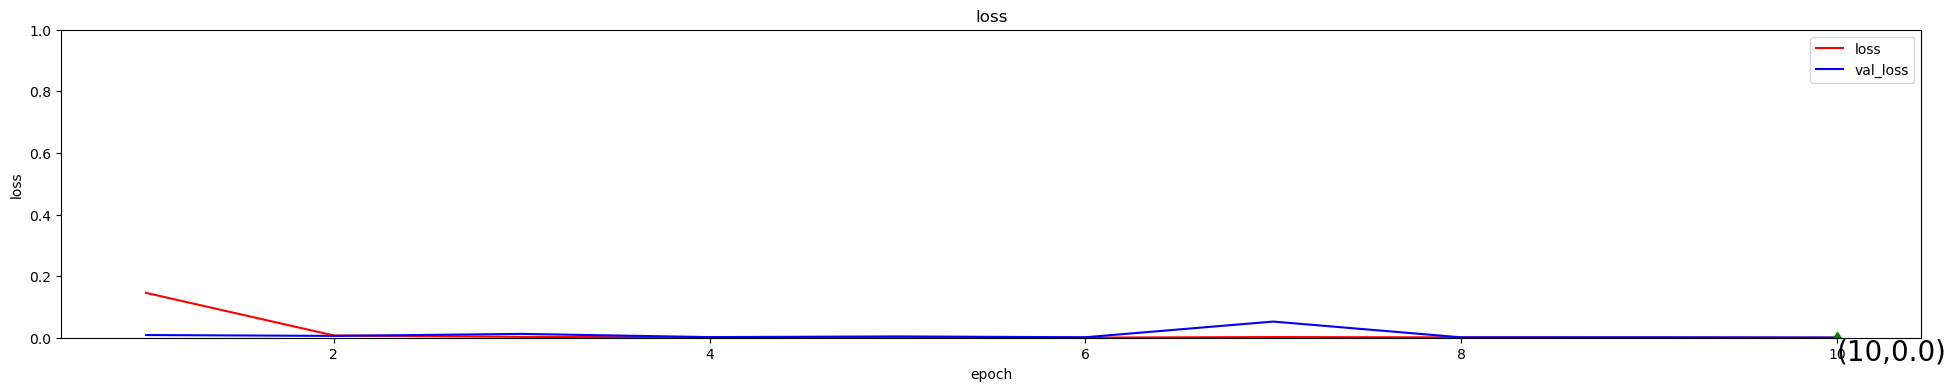

In [8]:
x = [i for i in range(1, epochs+1)]

min_valloss_x = val_loss.index(min(val_loss)) + 1
min_valloss_y = min(val_loss)

plt.figure(figsize=(24,4))
plt.plot(x, loss, 'r')     
plt.plot(x, val_loss, 'b')     # red dotted line (no marker)

plt.plot(min_valloss_x, min_valloss_y, 'd', color='g')
plt.text(min_valloss_x, min_valloss_y, "({},{})".format(min_valloss_x,round(min_valloss_y,2)), ha='left',va='top',fontsize=20)

plt.legend(['loss','val_loss'])
plt.ylim((0, 1.0))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss')
plt.savefig('../model/202303/{}_loss.png'.format(day),
            bbox_inches='tight',
            pad_inches=1,
            transparent=False)
plt.show()

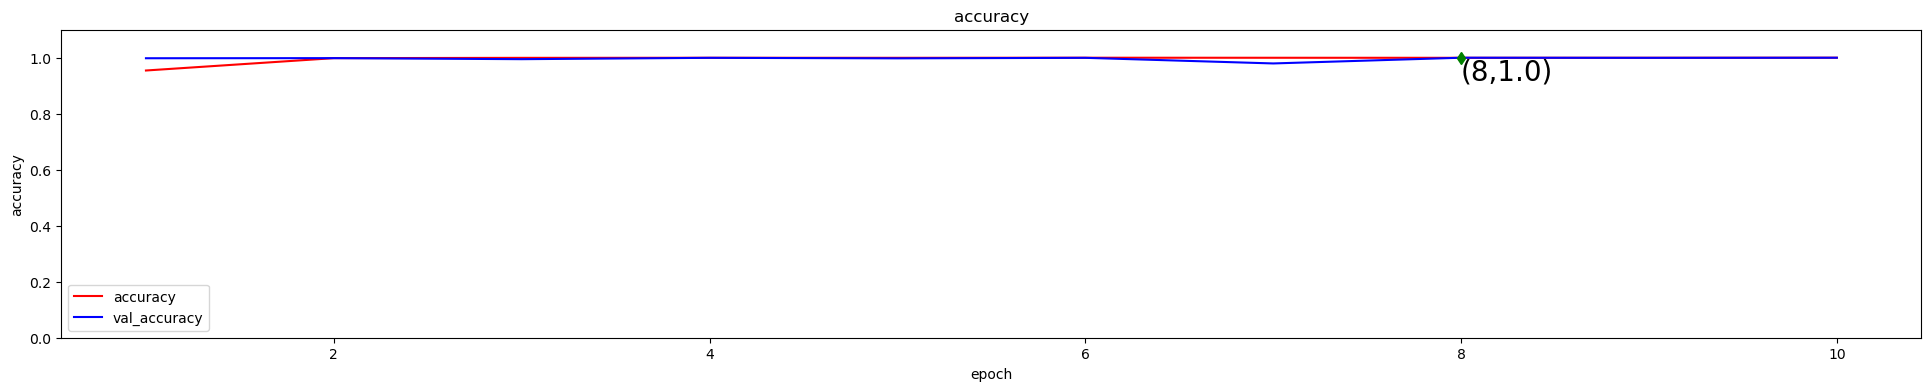

In [9]:
x = [i for i in range(1, epochs+1)]

max_valacc_x = val_accuracy.index(max(val_accuracy)) + 1
max_valacc_y = max(val_accuracy)

plt.figure(figsize=(24,4))
plt.plot(x, accuracy, 'r')     
plt.plot(x, val_accuracy, 'b')     # red dotted line (no marker)

plt.plot(max_valacc_x, max_valacc_y, 'd', color='g')
plt.text(max_valacc_x, max_valacc_y, "({},{})".format(max_valacc_x, round(max_valacc_y,2)), ha='left',va='top',fontsize=20)

plt.legend(['accuracy','val_accuracy'])
plt.ylim((0, 1.1))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('accuracy')
plt.savefig('../model/202303/{}_acc.png'.format(day),
            bbox_inches='tight',
            pad_inches=1,
            transparent=False)
plt.show()

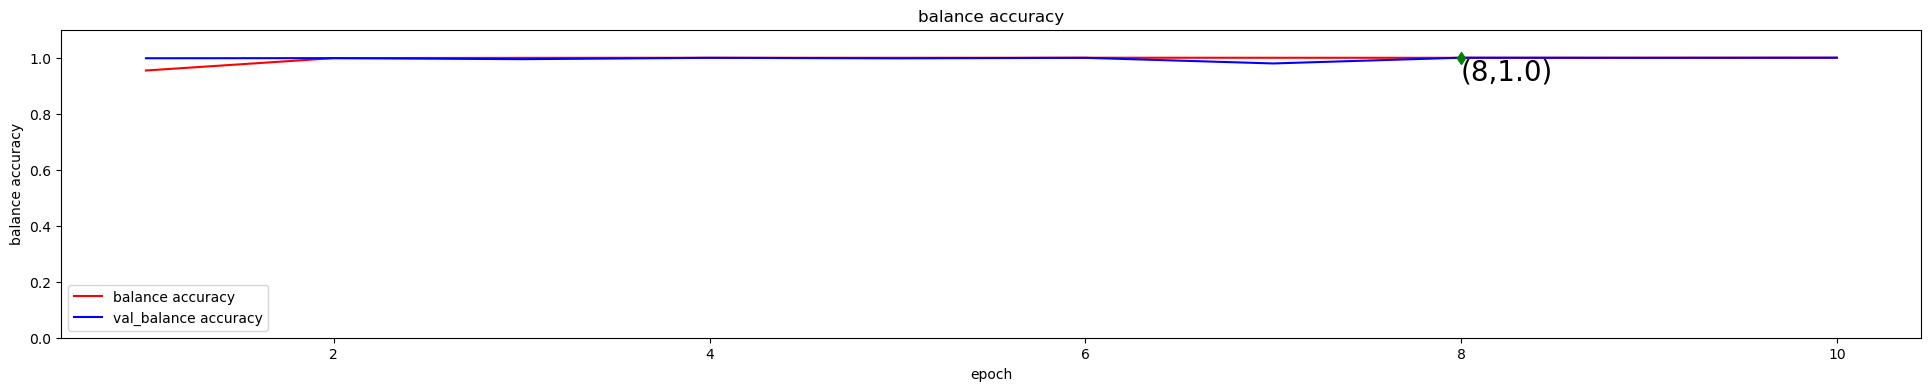

In [10]:
x = [i for i in range(1, epochs+1)]

max_valBlA_x = val_BlA.index(max(val_BlA)) + 1
max_valBlA_y = max(val_BlA)

plt.figure(figsize=(24,4))
plt.plot(x, BlA, 'r')     
plt.plot(x, val_BlA, 'b')     # red dotted line (no marker)

plt.plot(max_valBlA_x, max_valBlA_y, 'd', color='g')
plt.text(max_valBlA_x, max_valBlA_y, "({},{})".format(max_valBlA_x, round(max_valBlA_y,2)), ha='left',va='top',fontsize=20)

plt.legend(['balance accuracy','val_balance accuracy'])
plt.ylim((0, 1.1))
plt.xlabel('epoch')
plt.ylabel('balance accuracy')
plt.title('balance accuracy')
plt.savefig('../model/202303/{}_BlA.png'.format(day),
            bbox_inches='tight',
            pad_inches=1,
            transparent=False)
plt.show()

In [11]:
import json
# Get the dictionary containing each metric and the loss for each epoch
history_dict = history.history
# Save it under the form of a json file
json.dump(history_dict, open('../model/202303/{}.history'.format(day), 'w'))